# Animorphs Authorship Authenticity Analysis

### Ethan Henley

### Notebook 03: Support Vector Machine on Word2Vec

## Transfer Learning Supervised Modeling Process

Our problem was structured in a way such that we could not do an ordinary train/test split; ideally, our model makes a prediction on a single Animorphs book of unknown authorship, trained on all the other books in the series. In order to simulate this for validation, we adapted the strategy of leave-one-out cross validation, which generates seperate models each trained on all but one data point and then assesses the scores for each individual result to help determine the worthwhileness of a model. This is typically very expensive, but made sense for our dataset of only 54 book-level datapoints. We extrapolated this to leave-one-book-out cross validation for modeling based on chapter, as a model that requires other chapters from the same book to have known authorship to predict authorship of a single chapter would not fit our intended use case.

Ultimately, we determined that the results of the Word2Vec-based transfer learning process were likely not useful for stylometry or authorship analysis—they were more likely swayed by variation in content than in style across the texts, as visible in linearly sequential shifting predicted authenticity probabilities across the first 24 all-authentic books.

## Contents
- [Loading](#Loading)
- [Modeling](#Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Midway Reassessment](#Midway-Reassessment)

## Loading

Imports.

In [1]:
import numpy as np

import pandas as pd

from ast import literal_eval

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# a small module of functions i wrote for this project:
from small_lib import inacc_set, col_acc, do_gs

Load `chaps_df` and undo array-to-list.

In [2]:
chaps_df = pd.read_csv('../data/animorphs_chaps.csv')

for col in ['clean','clean_no_stops', 'vec_clean']:
    chaps_df[col] = chaps_df[col].map(literal_eval) # as lists
    
for col in ['vec_clean']:
    chaps_df[col] = chaps_df[col].map(np.array) # as array
    
chaps_df.head()

,book,chapter,text,authenticity,clean,clean_no_stops,vec_clean
0,1,1,"My name is Jake. That's my first name, obvious...",1,"[name, thats, first, name, obviously, cant, te...","[my, name, is, jake, thats, my, first, name, o...","[0.050813198, 0.21546867, -0.11217794, 0.05301..."
1,1,2,"""A flying saucer?"" Marco said. He did laugh. T...",1,"[flying, saucer, qstinpunc, laugh, looked, cou...","[a, flying, saucer, qstinpunc, marco, said, he...","[0.0059409393, 0.23846294, -0.09167185, 0.0067..."
2,1,3,<They have come to destroy you.>\nIt was stran...,1,"[anglepunc, come, destroy, anglepunc, strange,...","[anglepunc, they, have, come, to, destroy, you...","[0.00516426, 0.25513598, -0.040639274, -0.0519..."
3,1,4,<Yeerks!>\nThe twin red lights slowed. They tu...,1,"[anglepunc, yeerks, exclmpunc, anglepunc, twin...","[anglepunc, yeerks, exclmpunc, anglepunc, the,...","[-0.027513022, 0.24088845, 0.00715725, -0.0299..."
4,1,5,"The Hork-Bajir pointed his gun, or whatever it...",1,"[hork, odashpunc, bajir, pointed, gun, whateve...","[the, hork, odashpunc, bajir, pointed, his, gu...","[-0.037028935, 0.29484826, 0.030976577, -0.076..."


Load `books_df` and undo array-to-list.

In [3]:
books_df = pd.read_csv('../data/animorphs_books.csv')

for col in ['book_vec']:
    books_df[col] = books_df[col].map(literal_eval) # as lists
    
for col in ['book_vec']:
    books_df[col] = books_df[col].map(np.array) # as array
    
books_df.head()

,book,text,authenticity,clean,book_vec
0,1,"My name is Jake. That's my first name, obvious...",1,"['name', 'thats', 'first', 'name', 'obviously'...","[0.0010895184, 0.2081184, -0.05931624, 0.01286..."
1,2,My name is Rachel. I won't tell you my last na...,1,"['name', 'tell', 'last', 'name', 'none', 'us',...","[-0.00226549, 0.22271992, -0.065148115, 0.0113..."
2,3,My name is Tobias. A freak of nature. One of a...,1,"['name', 'freak', 'nature', 'kind', 'tell', 'l...","[-0.0129256295, 0.21558568, -0.05230921, 0.003..."
3,4,My name is Cassie.\nI can't tell you my last n...,1,"['name', 'cant', 'tell', 'last', 'name', 'wish...","[-0.0025382496, 0.21817772, -0.069260634, 0.00..."
4,5,My name is Marco.\nI can't tell you my last na...,1,"['name', 'cant', 'tell', 'last', 'name', 'live...","[-0.00024333985, 0.22410813, -0.054545447, 0.0..."


## Modeling

In [4]:
seed = 1007
cv_times = 5

We use a manually-written, not-cross-validated gridsearch `do_gs` available in the local module. This is desirable because of our leave-one-out training.

Generate results using leave-one-out training—each book's results are generated by a model trained on all other books. We have two different functions to get these results: one operates on books as wholes, the other averages chapters of specific books.

In [5]:
def pred_one_out_b(book_out, model, params, books_df=books_df):

    train_inds = books_df['book'] != book_out
    test_inds = books_df['book'] == book_out
    
    X_b = pd.DataFrame(list(books_df['book_vec'])).loc[train_inds]
    y_b = books_df['authenticity'].loc[train_inds]
    
    X_b_test = pd.DataFrame(list(books_df['book_vec'])).loc[test_inds]
    
    ss = StandardScaler()
    X_b = ss.fit_transform(X_b)
    X_b_test = ss.transform(X_b_test)

    model = do_gs(model, params, X_b, y_b)
    return (model.predict_proba(X_b_test)[:,1][0])

In [6]:
def pred_one_out_c(book_out, model, params, chaps_df=chaps_df):

    train_inds = chaps_df['book'] != book_out
    test_inds = chaps_df['book'] == book_out
    
    X_c = pd.DataFrame(list(chaps_df['vec_clean'])).loc[train_inds]
    y_c = chaps_df['authenticity'].loc[train_inds]
    
    X_c_test = pd.DataFrame(list(chaps_df['vec_clean'])).loc[test_inds]
    
    ss = StandardScaler()
    X_c = ss.fit_transform(X_c)
    X_c_test = ss.transform(X_c_test)

    model = do_gs(model, params, X_c, y_c)
    return (np.mean(model.predict(X_c_test)), 
            np.mean(model.predict_proba(X_c_test)[:,1]))

We will use a Support Vector Machine classifier, combined with our leave-one-out gridsearch, to independently generate predictions of authenticity for each individual book, using the data of all the other books in the corpus. This leave-one-out method allows us to maximize the training data, which is useful in this dataset where individual data points carry major unique characteristics and our overall $n$ is small.

We generate prediction results for each book in three ways: the probability of a book being authentic, and the average chapter prediction and chapter probability of authenticity based on the corpus of other books' chapters.

In [7]:
svm_params = {
    'C':np.logspace(2,4,5),
    'kernel':['rbf']
}
svm = SVC(random_state=seed, gamma='scale',
          max_iter=5e4, probability=True)

In [8]:
results = pd.DataFrame({'book':range(1,55)})
results['w2vsvm book pred proba'] = results['book'].map(
    lambda b:pred_one_out_b(b, svm, svm_params))
temp_c = results['book'].map(lambda b:pred_one_out_c(b, svm, svm_params))
results['w2vsvm chap pred avg'] = temp_c.map(lambda p:p[0])
results['w2vsvm chap pred proba avg'] = temp_c.map(lambda p:p[1])

In [9]:
results['authenticity'] = books_df['authenticity']

In [10]:
results.to_csv('../data/results.csv', index=False)

## Model Evaluation

In [11]:
print('Accuracy:')
{col:col_acc(results, col) 
 for col in ['w2vsvm chap pred avg',
             'w2vsvm chap pred proba avg',
             'w2vsvm book pred proba']}

Accuracy:


{'w2vsvm chap pred avg': 0.8703703703703703,
 'w2vsvm chap pred proba avg': 0.8703703703703703,
 'w2vsvm book pred proba': 0.8518518518518519}

None of these model types result in accuracy higher than 90%; this is troubling. 

We will inspect which books each individual prediction variety failed to predict properly.

In [12]:
results

,book,w2vsvm book pred proba,w2vsvm chap pred avg,w2vsvm chap pred proba avg,authenticity
0,1,0.991171,0.925926,0.740572,1
1,2,0.972882,0.869565,0.729202,1
2,3,0.978186,0.777778,0.720986,1
3,4,0.973608,0.920000,0.730618,1
4,5,0.988004,0.875000,0.796461,1
5,6,0.908672,0.840000,0.753434,1
6,7,0.968291,0.740741,0.693666,1
7,8,0.802080,0.863636,0.713113,1
8,9,0.970244,0.958333,0.745037,1
9,10,0.989242,0.923077,0.743199,1


In [13]:
print('Which books did each method get wrong?')
{col:inacc_set(results, col) 
 for col in ['w2vsvm chap pred avg',
             'w2vsvm chap pred proba avg',
             'w2vsvm book pred proba']}

Which books did each method get wrong?


{'w2vsvm chap pred avg': {25, 26, 29, 34, 50, 53, 54},
 'w2vsvm chap pred proba avg': {25, 28, 29, 34, 50, 53, 54},
 'w2vsvm book pred proba': {24, 25, 26, 34, 48, 50, 53, 54}}

Remarkably, each type makes at least one unique mistake, and none of them can accurately predict all of the *interesting* books—that is, the books whose authenticity might seem out of place in order; 25, 26, 32, 53, and 54. 

In [14]:
bads = sorted(list(inacc_set(results, 'w2vsvm book pred proba') |
                   inacc_set(results, 'w2vsvm chap pred proba avg') |
                   inacc_set(results, 'w2vsvm chap pred avg')))
bads

[24, 25, 26, 28, 29, 34, 48, 50, 53, 54]

In the plot below, blue, red, and pink dots will represent the three different methods of determining authenticity probability; black bars will represent the true authenticity of each book, and lime bars will represent the true authenticity of books which at least one of the methods assesses incorrectly. 

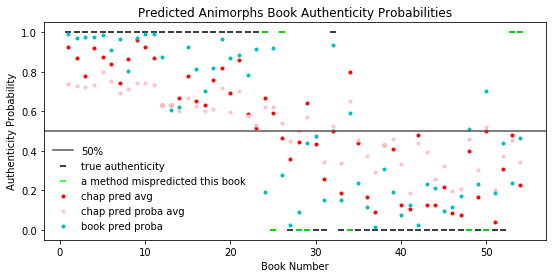

In [15]:
plt.figure(figsize=(9,4))
plt.axhline(.5,c='#555555')
plt.scatter(range(1,55),results['authenticity'],
            c='k', marker='_')
plt.scatter(bads, results.loc[results['book'].map(lambda b: b in bads),
                              'authenticity'],
            c='lime', marker='_', alpha=1)
plt.scatter(range(1,55),results['w2vsvm chap pred avg'],
            c='r', marker='.')
plt.scatter(range(1,55),results['w2vsvm chap pred proba avg'],
            c='pink', marker='.')
plt.scatter(range(1,55),results['w2vsvm book pred proba'], 
            c='c', marker='.')
plt.legend(['50%','true authenticity', 'a method mispredicted this book',
            'chap pred avg','chap pred proba avg','book pred proba'],
           fancybox=True, framealpha=0)
plt.title('Predicted Animorphs Book Authenticity Probabilities')
plt.xlabel('Book Number')
plt.ylabel('Authenticity Probability')
plt.savefig('../figures/first_results.png');

The above plot contains a lot of information; it shows predicted authenticity probabilities for each W2V-based SVM for each Animorphs book. Ideally there would be no appearance of a linear relationship here, but because the books were written sequentially, it makes sense for one to have a small presence. 

However, especially for averaged chapter-based predictions, there seems to be a consistent and notable linear decline in probability over increasing book number. Notably, the books most often inaccurately predicted are those 'out of place' in order, early ghostwritten books and authentic books surrounded by ghostwritten books. We believe that this is a sign of a flaw in the model, that it registers a shift in content more than any shift in author's style. This would mean that the Word2Vec word embedding is inappropriate for stylometry. 

## Midway Reassessment

Though word embedding's appropriateness for stylometry is disputed, [these](https://pdfs.semanticscholar.org/3fd9/c3a45629393465e7258dee0f1eaab32ea4bc.pdf) [papers](https://www.aclweb.org/anthology/Q15-1016.pdf), suggest that it is especially poorly-suited to authorship analysis, as it obscures the author specific quality of word choice for a more general, content-based view of text. 

Because Word2Vec analysis seems unfruitful, we treat this transfer learning model as our baseline and attempt some more traditional stylometric analyses that are clearly geared toward style rather than content. Where these methods abstracted words and texts to vectors, we will instead model off of straightforward word (and punctuation) counts to discern authenticity.

[Continue to next notebook.](./04_classifiers_on_words.ipynb)